### This notebook generate the line benefits from the operational cost

In [46]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [47]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [48]:
#%% Setting up the path a cases
DirName  = os.getcwd()

# CSV_name =  'OC_fy_(3, 1)h_64e_0.000625lr_0dor_0np_Truero_64bs_0.0ill_TrueMAE'
# CSV_name =  'OC_fy_(3, 2)h_64e_0.0025lr_0dor_0np_Truero_64bs_0.16ill_TrueMAE'

CaseName_Base     = '9n'
CaseName_ByStages = CaseName_Base + '_ByStages'

CSV_name =  'oT_LineBenefit_Data_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [49]:
df_1 = pd.read_csv(_path_0+'/3.Out'+'/'+CSV_name+'.csv', index_col=[0,1,2])
diff_df_1 = df_1

In [50]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
# diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [51]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [52]:
diff_df_1.head()

Network_Line_In_Node_1_Node_6_cac1  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        9.749146e-16   
                01-01 01:00:00+01:00                        2.428613e-17   
                01-01 02:00:00+01:00                        1.249001e-16   
                01-01 03:00:00+01:00                       -1.994932e-16   
                01-01 04:00:00+01:00                        3.001072e-16   

                                      Network_Line_In_Node_1_Node_6_cac2  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        9.020562e-16   
                01-01 01:00:00+01:00                        7.736867e-16   
                01-01 02:00:00+01:00                        7.632783e-17   
                01-01 03:00:00+01:00                        1.994932e-16   
                01-01 04:00:00+01:00                        2.498002e-16   

                                      Network_Line_In_Node_1_Node_6_cac3  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        1.925543e-15   
                01-01 01:00:00+01:00                        1.575129e-15   
                01-01 02:00:00+01:00                        7.736867e-16   
                01-01 03:00:00+01:00                        3.747003e-16   
                01-01 04:00:00+01:00                        1.006140e-16   

                                      Network_Line_In_Node_2_Node_3_cac1  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        7.771561e-16   
                01-01 01:00:00+01:00                        2.740863e-16   
                01-01 02:00:00+01:00                        3.018419e-16   
                01-01 03:00:00+01:00                        2.758210e-16   
                01-01 04:00:00+01:00                        1.752071e-16   

                                      Network_Line_In_Node_2_Node_3_cac2  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        7.008283e-16   
                01-01 01:00:00+01:00                        7.632783e-17   
                01-01 02:00:00+01:00                       -1.974115e-15   
                01-01 03:00:00+01:00                        1.509209e-16   
                01-01 04:00:00+01:00                        3.261280e-16   

                                      Network_Line_In_Node_2_Node_3_cac3  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        9.263423e-16   
                01-01 01:00:00+01:00                        4.857226e-17   
                01-01 02:00:00+01:00                       -3.747003e-16   
                01-01 03:00:00+01:00                       -7.459311e-17   
                01-01 04:00:00+01:00                        4.510281e-16   

                                      Network_Line_In_Node_2_Node_6_cac1  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        7.494005e-16   
                01-01 01:00:00+01:00                       -1.249001e-16   
                01-01 02:00:00+01:00                       -6.487866e-16   
                01-01 03:00:00+01:00                       -6.748074e-16   
                01-01 04:00:00+01:00                        3.001072e-16   

                                      Network_Line_In_Node_2_Node_6_cac2  \
Period Scenario LoadLevel                                                  
2030   sc01     01-01 00:00:00+01:00                        6.002143e-16   
                01-01 01:00:00+01:00                       -1.249001e-16   
   

In [53]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [54]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_6_cac1,Network_Line_In_Node_1_Node_6_cac2,Network_Line_In_Node_1_Node_6_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Network_Line_In_Node_2_Node_6_cac1,Network_Line_In_Node_2_Node_6_cac2,Network_Line_In_Node_2_Node_6_cac3,Network_Line_In_Node_3_Node_4_cac1,...,Network_Line_In_Node_6_Node_7_cac3,Network_Line_In_Node_6_Node_8_cac1,Network_Line_In_Node_6_Node_8_cac2,Network_Line_In_Node_6_Node_8_cac3,Network_Line_In_Node_7_Node_8_cac1,Network_Line_In_Node_7_Node_8_cac2,Network_Line_In_Node_7_Node_8_cac3,Network_Line_In_Node_8_Node_9_cac1,Network_Line_In_Node_8_Node_9_cac2,Network_Line_In_Node_8_Node_9_cac3
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,9.749146e-16,9.020562e-16,1.925543e-15,7.771561e-16,7.008283e-16,9.263423e-16,7.494005e-16,6.002143e-16,7.008283e-16,1.051242e-15,...,1.502271e-15,7.251144e-16,7.008283e-16,7.008283e-16,4.510281e-16,8.743006e-16,6.765422e-16,9.749146e-16,9.749146e-16,9.020562e-16
01-01 01:00:00+01:00,2.428613e-17,7.736867e-16,1.575129e-15,2.740863e-16,7.632783e-17,4.857226e-17,-1.249001e-16,-1.249001e-16,-1.734723e-16,4.996004e-16,...,2.199629e-15,2.255141e-16,3.625572e-15,3.261280e-16,-2.983724e-16,-1.491862e-16,-2.428613e-17,-1.734723e-16,1.491862e-16,1.249001e-16
01-01 02:00:00+01:00,1.249001e-16,7.632783e-17,7.736867e-16,3.018419e-16,-1.974115e-15,-3.747003e-16,-6.487866e-16,-1.325329e-15,-6.730727e-16,-4.857226e-17,...,4.267420e-16,6.002143e-16,0.000000e+00,0.000000e+00,-4.510281e-16,-7.494005e-16,-1.734723e-16,2.473716e-15,1.051242e-15,4.857226e-17
01-01 03:00:00+01:00,-1.994932e-16,1.994932e-16,3.747003e-16,2.758210e-16,1.509209e-16,-7.459311e-17,-6.748074e-16,-4.753142e-16,7.459311e-17,-1.752071e-16,...,-1.474515e-15,2.498002e-16,1.006140e-16,7.459311e-17,-1.006140e-16,8.257284e-16,-5.741935e-16,-1.524822e-15,1.752071e-16,4.996004e-16
01-01 04:00:00+01:00,3.001072e-16,2.498002e-16,1.006140e-16,1.752071e-16,3.261280e-16,4.510281e-16,3.001072e-16,2.255141e-16,-1.491862e-16,1.099815e-15,...,1.509209e-16,1.800643e-15,4.996004e-16,3.504141e-16,-1.994932e-16,-1.752071e-16,4.510281e-16,7.754214e-16,5.759282e-16,8.257284e-16


In [55]:
ddf_1 = diff_df_1.stack()

In [56]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [57]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [58]:
ddf_1.head()

Value
LoadLevel            Execution                                       
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_6_cac1  9.749146e-16
                     Network_Line_In_Node_1_Node_6_cac2  9.020562e-16
                     Network_Line_In_Node_1_Node_6_cac3  1.925543e-15
                     Network_Line_In_Node_2_Node_3_cac1  7.771561e-16
                     Network_Line_In_Node_2_Node_3_cac2  7.008283e-16

In [59]:
ddf_1 = ddf_1.reset_index()

In [60]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [61]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [62]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,-8.222589e-16,1900-12-30 23:00:00
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,-8.222589e-16,1900-12-30 23:00:00
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-1.498801e-15,1900-12-30 23:00:00
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,3.018419e-16,1900-12-30 23:00:00
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,-6.002143e-16,1900-12-30 23:00:00


#### Getting day of year and month

In [63]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [64]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac1,9.749146e-16,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac2,9.020562e-16,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_6_cac3,1.925543e-15,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,7.771561e-16,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,7.008283e-16,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [65]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [66]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
314491,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac2,-8.222589e-16,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac2_23
314492,12-30 23:00:00+01:00,Network_Line_In_Node_7_Node_8_cac3,-8.222589e-16,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_7_Node_8_cac3_23
314493,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac1,-1.498801e-15,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac1_23
314494,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac2,3.018419e-16,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac2_23
314495,12-30 23:00:00+01:00,Network_Line_In_Node_8_Node_9_cac3,-6.002143e-16,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_8_Node_9_cac3_23


In [67]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [68]:
table.tail()

Variable   Network_Line_In_Node_1_Node_6_cac1_0  \
Month Day                                         
12    360                          0.000000e+00   
      361                         -2.428613e-17   
      362                          1.549108e-15   
      363                         -3.472916e-15   
      364                          2.428613e-17   

Variable   Network_Line_In_Node_1_Node_6_cac1_1  \
Month Day                                         
12    360                          0.000000e+00   
      361                         -7.285839e-17   
      362                         -7.736867e-16   
      363                         -1.524822e-15   
      364                         -4.232725e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_10  \
Month Day                                          
12    360                          -2.428613e-17   
      361                          -2.740863e-16   
      362                           3.323730e-15   
      363                          -1.249001e-16   
      364                          -1.032507e-14   

Variable   Network_Line_In_Node_1_Node_6_cac1_11  \
Month Day                                          
12    360                           9.887924e-17   
      361                          -8.014422e-16   
      362                          -8.743006e-15   
      363                           5.676015e-15   
      364                          -5.499073e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_12  \
Month Day                                          
12    360                          -2.255141e-16   
      361                           2.602085e-17   
      362                           1.700029e-15   
      363                           5.238865e-16   
      364                           4.250073e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_13  \
Month Day                                          
12    360                          -2.498002e-16   
      361                          -2.498002e-16   
      362                          -4.229256e-15   
      363                           6.765422e-16   
      364                           1.774622e-15   

Variable   Network_Line_In_Node_1_Node_6_cac1_14  \
Month Day                                          
12    360                           2.498002e-16   
      361                          -7.459311e-17   
      362                          -3.549244e-15   
      363                           3.261280e-16   
      364                          -1.752071e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_15  \
Month Day                                          
12    360                          -3.504141e-16   
      361                           6.505213e-16   
      362                          -3.486794e-16   
      363                           6.826137e-15   
      364                          -4.510281e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_16  \
Month Day                                          
12    360                           2.983724e-16   
      361                          -4.492934e-16   
      362                          -1.325329e-15   
      363                          -1.977585e-16   
      364                          -5.724587e-16   

Variable   Network_Line_In_Node_1_Node_6_cac1_17  ...  \
Month Day                                         ...   
12    360                          -6.487866e-16  ...   
      361                           1.675743e-15  ...   
      362                           2.428613e-17  ...   
      363                           7.632783e-17  ...   
      364                           3.989864e-16  ...   

Variable   Network_Line_In_Node_8_Node_9_cac3_21  \
Month Day                                          
12    360                           5.724587e-16   
      361                          -2.983724e-16   
      362                           3.858025e-15   
      363                           9.575674e-16   
      364        

In [69]:
table = table.reset_index()

In [70]:
table = table.set_index(['Day'])

In [71]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_6_cac1_0,Network_Line_In_Node_1_Node_6_cac1_1,Network_Line_In_Node_1_Node_6_cac1_10,Network_Line_In_Node_1_Node_6_cac1_11,Network_Line_In_Node_1_Node_6_cac1_12,Network_Line_In_Node_1_Node_6_cac1_13,Network_Line_In_Node_1_Node_6_cac1_14,Network_Line_In_Node_1_Node_6_cac1_15,Network_Line_In_Node_1_Node_6_cac1_16,...,Network_Line_In_Node_8_Node_9_cac3_21,Network_Line_In_Node_8_Node_9_cac3_22,Network_Line_In_Node_8_Node_9_cac3_23,Network_Line_In_Node_8_Node_9_cac3_3,Network_Line_In_Node_8_Node_9_cac3_4,Network_Line_In_Node_8_Node_9_cac3_5,Network_Line_In_Node_8_Node_9_cac3_6,Network_Line_In_Node_8_Node_9_cac3_7,Network_Line_In_Node_8_Node_9_cac3_8,Network_Line_In_Node_8_Node_9_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,0.000000e+00,0.000000e+00,-2.428613e-17,9.887924e-17,-2.255141e-16,-2.498002e-16,2.498002e-16,-3.504141e-16,2.983724e-16,...,5.724587e-16,3.747003e-16,1.526557e-16,-2.200063e-15,7.251144e-16,-1.752071e-16,1.249001e-16,-3.989864e-16,-3.774758e-15,4.857226e-17
361,12,-2.428613e-17,-7.285839e-17,-2.740863e-16,-8.014422e-16,2.602085e-17,-2.498002e-16,-7.459311e-17,6.505213e-16,-4.492934e-16,...,-2.983724e-16,1.249001e-16,-2.576064e-15,-1.923808e-15,3.747003e-16,-7.251144e-16,2.255141e-16,-1.373901e-15,3.243933e-16,-1.150122e-15
362,12,1.549108e-15,-7.736867e-16,3.323730e-15,-8.743006e-15,1.700029e-15,-4.229256e-15,-3.549244e-15,-3.486794e-16,-1.325329e-15,...,3.858025e-15,-2.012279e-16,-2.428613e-17,-9.003215e-16,-5.030698e-17,-1.875236e-15,-1.125836e-15,-5.325601e-15,-7.511353e-16,9.749146e-16
363,12,-3.472916e-15,-1.524822e-15,-1.249001e-16,5.676015e-15,5.238865e-16,6.765422e-16,3.261280e-16,6.826137e-15,-1.977585e-16,...,9.575674e-16,1.491862e-16,2.775558e-17,1.491862e-16,-1.301043e-15,2.428613e-17,-1.399922e-15,1.047773e-15,2.428613e-17,7.997075e-16
364,12,2.428613e-17,-4.232725e-16,-1.032507e-14,-5.499073e-16,4.250073e-16,1.774622e-15,-1.752071e-16,-4.510281e-16,-5.724587e-16,...,-8.187895e-16,-1.977585e-16,-6.002143e-16,-1.399922e-15,1.049508e-15,-1.476250e-15,-2.740863e-16,1.075529e-15,-2.220446e-16,1.266348e-16


#### Split data table into data X and class labels y

In [72]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [73]:
print(X)
print(y)

[[ 9.74914593e-16  2.42861287e-17 -1.25008510e-16 ...  3.24393290e-16
   1.32532874e-15 -1.92510938e-15]
 [-9.71445147e-17 -6.97358837e-16  2.55351296e-15 ... -1.90125693e-15
  -1.24900090e-16  1.08992676e-14]
 [ 9.76649317e-16 -4.85722573e-17 -4.22491903e-15 ...  7.49400542e-16
  -1.09981468e-15  9.49977944e-16]
 ...
 [ 1.54910806e-15 -7.73686670e-16  3.32373018e-15 ... -5.32560107e-15
  -7.51135265e-16  9.74914593e-16]
 [-3.47291640e-15 -1.52482194e-15 -1.24900090e-16 ...  1.04777298e-15
   2.42861287e-17  7.99707522e-16]
 [ 2.42861287e-17 -4.23272528e-16 -1.03250741e-14 ...  1.07552856e-15
  -2.22044605e-16  1.26634814e-16]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4

## PCA step by step

#### Standardizing of the data

In [74]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [75]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.02817683+0.j         -0.07801701+0.j         -0.03960772+0.j
  ...  0.00373907+0.00561458j -0.00830231+0.j
  -0.00495721+0.j        ]
 [ 0.02149235+0.j         -0.08298812+0.j         -0.04017592+0.j
  ... -0.00229428-0.0031672j   0.00378307+0.j
  -0.00053095+0.j        ]
 [ 0.02206451+0.j         -0.07087427+0.j         -0.06037144+0.j
  ... -0.01191768-0.00139758j  0.00289255+0.j
   0.01200198+0.j        ]
 ...
 [ 0.01249201+0.j         -0.01041756+0.j          0.03994117+0.j
  ... -0.01127514+0.01024469j -0.03720415+0.j
   0.00036909+0.j        ]
 [ 0.01457338+0.j         -0.00980208+0.j          0.01691857+0.j
  ...  0.00620556-0.01050989j  0.04226991+0.j
  -0.00601011+0.j        ]
 [ 0.01804942+0.j         -0.02104469+0.j          0.00707921+0.j
  ...  0.02411759-0.03090391j  0.08105314+0.j
  -0.01417239+0.j        ]]

Eigenvalues 
[ 5.60967207e+01+0.00000000e+00j  3.31564700e+01+0.00000000e+00j
  2.89783991e+01+0.00000000e+00j  2.48517670e+01+0.00000000e+00j
  

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [76]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [77]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
56.09672072302051
33.156469973652996
28.978399116281114
24.851766971821217
23.876289534009313
22.970206392997092
22.69609481670214
21.350904602192664
18.94388718541144
17.585075384388265
16.885225724283554
16.615126699232867
15.995143028968412
15.659891567706335
15.39546102273626
14.799359081635012
14.122674132044505
13.888474266511892
13.700840596264086
12.594475077086397
12.534880915333138
11.801316017629835
11.439443193292288
10.920635127398782
9.725973126508602
9.33355963476096
9.155589246952498
8.437961211158772
6.138783886709597
5.474993990091082
4.9695175794957445
4.356112324087426
4.072758487089994
3.908686646116444
3.7181709650088774
3.6852690765659517
3.5855107889097773
3.5012625989378083
3.424593838302251
3.3633809731746425
3.326178300787136
3.2505278308802854
3.2189271392878185
3.182368686885554
3.1048305231783764
3.0360382659508676
2.9938870516923806
2.9820135025280785
2.923686752007264
2.863021102700487
2.8408968921390336
2.813502086824279

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [78]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [79]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

(6.474838987604417+0j) 0
(10.301850650848465+0j) 1
(13.64661779548942+0j) 2
(16.51507762034286+0j) 3
(19.270945135619797+0j) 4
(21.922230023395134+0j) 5
(24.541876193286914+0j) 6
(27.00625678019292+0j) 7
(29.192812745389404+0j) 8
(31.222530886330123+0j) 9
(33.17147043974731+0j) 10
(35.08923441506703+0j) 11
(36.935438156772975+0j) 12
(38.7429462456127+0j) 13
(40.51993302803704+0j) 14
(42.22811607221995+0j) 15
(43.858194263971875+0j) 16
(45.46124045811864+0j) 17
(47.042629453986265+0j) 18
(48.496318675147215+0j) 19
(49.943129372983094+0j) 20
(51.305269977124205+0j) 21
(52.62564221688722+0j) 22
(53.886132191718616+0j) 23
(55.00873096719513+0j) 24
(56.086036289812334+0j) 25
(57.142799776993016+0j) 26
(58.1167326472523+0j) 27
(58.82528809815647+0j) 28
(59.45722707938455+0j) 29
(60.03082257228651+0j) 30
(60.5336171304506+0j) 31
(61.00370620338433+0j) 32
(61.45485764967944+0j) 33
(61.884019248013985+0j) 34
(62.30938321919118+0j) 35
(62.723232812309774+0j) 36
(63.127358245833385+0j) 37
(63.522

Then

c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


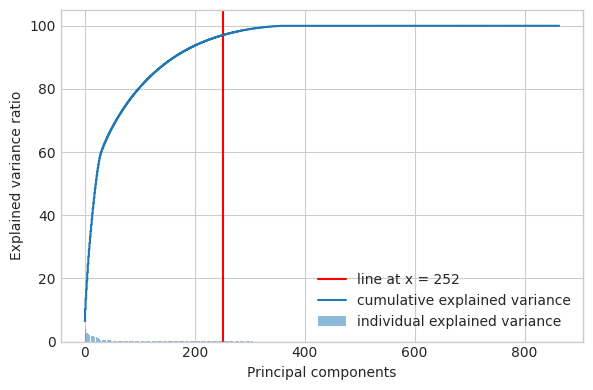

In [80]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [81]:
labels = np.unique(y, axis=0)

In [82]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

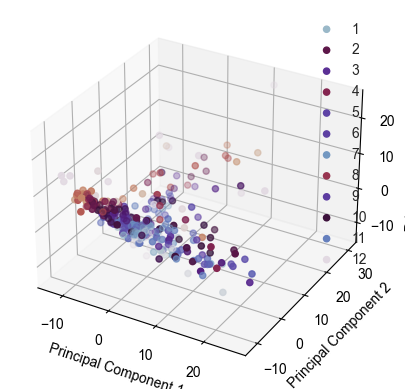

In [83]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

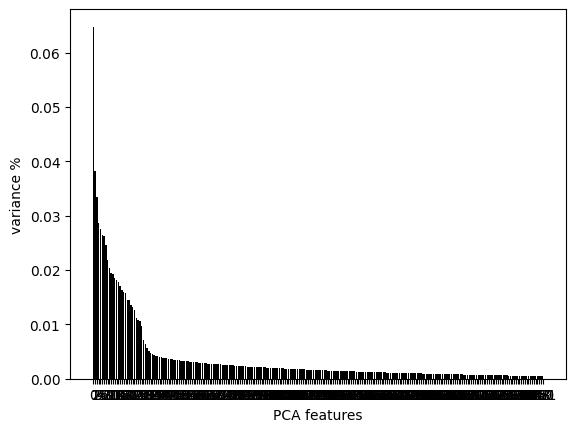

In [84]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [85]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [86]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,-2.336251,2.600761,-5.815126,2.326552,1.883084,0.741345,1.514190,0.354396,1.512499,1.843684,...,-0.459210,0.127390,0.331706,-0.275056,-0.090121,0.152784,0.000243,-0.421486,-0.712601,0.112843
1,-5.742003,-6.202261,4.263883,0.478863,-6.223411,-1.446202,10.663942,-4.368314,-10.702506,7.531487,...,0.376762,0.331347,0.336810,0.572602,0.435806,-0.249068,-0.367506,0.257298,0.920743,0.214498
2,-1.714817,-0.513721,-4.284245,-2.169318,-1.953449,-3.733732,1.619139,2.132186,2.528176,-3.140346,...,-1.295441,-0.514013,1.293023,-0.484002,-0.921978,-0.284009,-1.068362,0.329652,0.271878,-0.037889
3,-2.532318,0.811830,-3.030057,4.590683,-0.947800,5.163219,0.984228,-1.883643,2.606801,0.928238,...,0.082045,1.003545,-0.911107,0.251391,0.249286,-0.863095,-0.889182,-2.161068,1.260028,-1.650287
4,-4.704451,-5.061033,1.080942,2.183978,-5.959187,-4.642701,4.865461,-0.094192,-4.487219,-1.834275,...,-0.362615,-0.996105,0.266924,-0.524247,-0.726453,-0.299182,0.663862,-0.854758,0.918672,0.031338


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

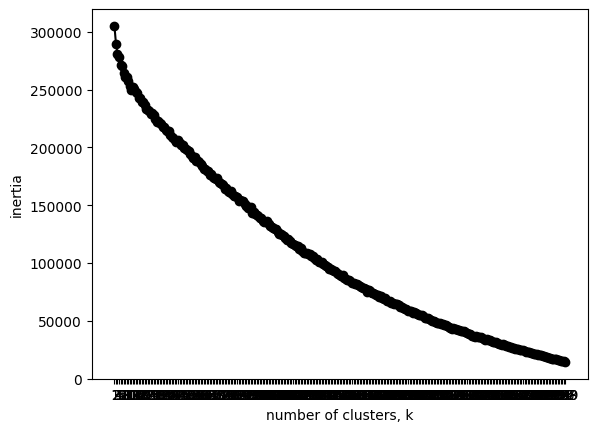

In [87]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [88]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  18


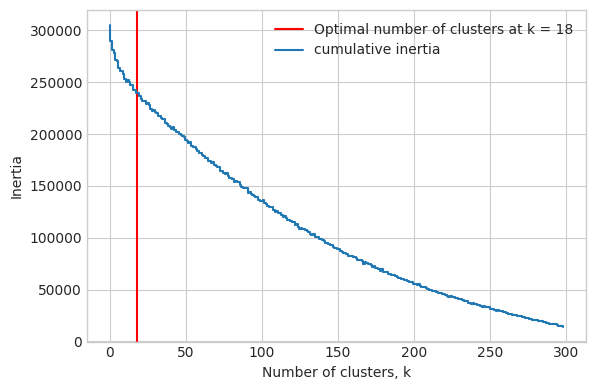

In [89]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [90]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering
End of the process...
